In [1]:
# train_and_explain.py
"""
Full training + explainability script.
- Expects CSV path: ./Final_data_for_claim_demo_model.csv
- Target column: 'target_next_year'
- Saves best model: models/best_model.pkl
- Saves feature importances: models/feature_importances.csv
- Shows SHAP + LIME outputs (plots)
"""

import os, sys, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from math import sqrt

# sklearn imports
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor

# category encoders (target encoder)
from category_encoders import TargetEncoder

# Optional boosters
try:
    import lightgbm as lgb
except Exception:
    lgb = None
try:
    import xgboost as xgb
except Exception:
    xgb = None
try:
    from catboost import CatBoostRegressor
except Exception:
    CatBoostRegressor = None

# SciKeras (for TF-based ANN)
try:
    from scikeras.wrappers import KerasRegressor
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
except Exception:
    KerasRegressor = None
    tf = None

# SHAP & LIME
try:
    import shap
except Exception:
    shap = None
try:
    from lime.lime_tabular import LimeTabularExplainer
except Exception:
    LimeTabularExplainer = None

In [22]:
df['Claim_Year'] = df['Claim_Year'].replace(np.nan,1999.0)

In [18]:
df['Claim_Year'].unique()

array([  nan, 2020., 2021., 2024., 2025., 2022., 2023.])

In [11]:


# -------------------------
# Config
# -------------------------
DATA_PATH = "Final_data_for_claim_demo_model.csv"
TARGET = "target_next_year"
OUT_DIR = "models"
os.makedirs(OUT_DIR, exist_ok=True)
RANDOM_STATE = 42

# -------------------------
# Load data
# -------------------------
df = pd.read_csv(DATA_PATH)
print("Loaded:", df.shape)
if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not found. Columns: {df.columns.tolist()}")

# drop rows with missing target
df = df.dropna(subset=[TARGET]).reset_index(drop=True)

# optionally sample if huge (comment out if you want full dataset)
MAX_ROWS = 300000
if df.shape[0] > MAX_ROWS:
    print(f"Sampling down to {MAX_ROWS} rows for speed")
    df = df.sample(MAX_ROWS, random_state=RANDOM_STATE).reset_index(drop=True)

Loaded: (161718, 52)


In [13]:
# -------------------------
# Feature types
# -------------------------
X = df.drop(columns=[TARGET])
y = df[TARGET].values
y_trans = np.log1p(y)  # model on log target for stability

numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

# Heuristics for encoding
HIGH_CARD_TH = 10
high_card_cols = [c for c in categorical_cols if X[c].nunique() > HIGH_CARD_TH]
low_card_cols = [c for c in categorical_cols if 2 <= X[c].nunique() <= HIGH_CARD_TH]
binary_cols = [c for c in categorical_cols if X[c].nunique() == 2]

print("High-card columns (TargetEncode):", high_card_cols)
print("Low-card columns (OneHot):", low_card_cols)
print("Binary columns (OneHot):", binary_cols)

Numeric cols: ['Unnamed: 0', 'Claim_Year', 'total_claim_amount', 'mean_monthly_amount', 'std_monthly_amount', 'coef_var', 'skew_monthly_amount', 'claim_month_entropy', 'months_with_claims', 'max_monthly_amount', 'min_monthly_amount', 'Q1_amount', 'Q2_amount', 'Q3_amount', 'Q4_amount', 'lag1_total', 'yoy_change', 'age', 'is_high_cost_next_year', 'lag1_count', 'lag2_total', 'lag2_count', 'lag3_total', 'lag3_count', 'rolling_3yr_sum', 'rolling_3yr_avg', 'rolling_3yr_max', 'rolling_3yr_count', 'rolling_5yr_sum', 'rolling_5yr_avg', 'rolling_5yr_max', 'rolling_5yr_count', 'std_3yr', 'std_5yr', 'cv_3yr', 'years_since_last_claim', 'claim_free_years_last_5', 'longest_claim_streak', 'pct_active_years', 'avg_amount_per_claim', 'max_to_mean_ratio', 'slope_3yr', 'age_x_lag1', 'first_claim_year', 'last_claim_year']
Categorical cols: ['Scheme Category/ Section Name', 'Status of Member_memb', 'Status of Registration', 'Gender', 'Region of Member', 'Industry']
High-card columns (TargetEncode): ['Scheme

In [14]:
# -------------------------
# Preprocessing pipelines (with compatibility for OneHotEncoder)
# -------------------------
sk_ver = tuple(map(int, sklearn.__version__.split(".")[:2]))
if sk_ver >= (1,2):
    onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
onehot_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", onehot)])
target_pipe = Pipeline([("target_enc", TargetEncoder())])  # TargetEncoder expects DataFrame input in fit

transformers = []
if len(low_card_cols) > 0:
    transformers.append(("onehot", onehot_pipe, low_card_cols))
if len(high_card_cols) > 0:
    transformers.append(("target", target_pipe, high_card_cols))
if len(numeric_cols) > 0:
    transformers.append(("num", num_pipe, numeric_cols))

preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

In [26]:
# -------------------------
# Train-test split (Year-based)
# -------------------------

YEAR_COLUMN = "Claim_Year"  # 🔹 Change this to your actual year column name

if YEAR_COLUMN not in df.columns:
    raise ValueError(f"Expected a column named '{YEAR_COLUMN}' for year-based split.")

# Make sure year column is integer or comparable
df[YEAR_COLUMN] = df[YEAR_COLUMN].astype(int)

# Split based on year threshold
train_df = df[df[YEAR_COLUMN] < 2024]
test_df = df[df[YEAR_COLUMN] > 2023]

if train_df.empty or test_df.empty:
    raise ValueError("Check your data — no records found for either <2024 or ==2025!")

print(f"Train year range: {train_df[YEAR_COLUMN].min()} - {train_df[YEAR_COLUMN].max()}")
print(f"Test year range: {test_df[YEAR_COLUMN].min()} - {test_df[YEAR_COLUMN].max()}")
print(f"Train size: {train_df.shape[0]}, Test size: {test_df.shape[0]}")

# Separate features and target
X_train = train_df.drop(columns=[TARGET])
y_train = np.log1p(train_df[TARGET].values)

X_test = test_df.drop(columns=[TARGET])
y_test = np.log1p(test_df[TARGET].values)

# Fit preprocessor only on training data
preprocessor.fit(X_train, y_train)

# Preprocess
X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print("Train/Test after year-based split:", X_train.shape, X_test.shape)


Train year range: 1999 - 2023
Test year range: 2024 - 2025
Train size: 136480, Test size: 25238
Train/Test after year-based split: (136480, 51) (25238, 51)


In [ ]:
No run this code
# -------------------------
# Train-test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=RANDOM_STATE)
print("Train/test:", X_train.shape, X_test.shape)

# Fit preprocessor on X_train (important for TargetEncoder)
preprocessor.fit(X_train, y_train)
# Preprocessed arrays (useful for SHAP and permutation importance)
X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# helper eval - version-safe RMSE
def eval_model(model, X_raw, y_test_trans):
    if hasattr(model, "named_steps"):
        y_pred_trans = model.predict(X_raw)
    else:
        # model expects preprocessed features
        try:
            Xp = preprocessor.transform(X_raw)
        except Exception:
            Xp = X_raw
        y_pred_trans = model.predict(Xp)
    y_pred = np.expm1(y_pred_trans)
    y_true = np.expm1(y_test_trans)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r2 = r2_score(y_true, y_pred)
    return {"mae": mae, "rmse": rmse, "r2": r2, "y_true": y_true, "y_pred": y_pred}

results = {}

Train/test: (129374, 51) (32344, 51)


In [27]:
# -------------------------
# Train LightGBM
# -------------------------
if lgb is not None:
    print("\nTraining LightGBM (light tune)...")
    pipe_lgb = Pipeline([("pre", preprocessor), ("model", lgb.LGBMRegressor(random_state=RANDOM_STATE))])
    params = {"model__n_estimators":[200,500], "model__learning_rate":[0.05,0.1], "model__num_leaves":[31,63]}
    search = RandomizedSearchCV(pipe_lgb, params, n_iter=4, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, random_state=RANDOM_STATE)
    search.fit(X_train, y_train)
    best_lgb = search.best_estimator_
    results["LightGBM"] = eval_model(best_lgb, X_test, y_test)
    print("LightGBM:", results["LightGBM"])
else:
    print("LightGBM not installed. Skipping.")



Training LightGBM (light tune)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7443
[LightGBM] [Info] Number of data points in the train set: 136480, number of used features: 58
[LightGBM] [Info] Start training from score 1.409453
LightGBM: {'mae': 3406.340761746909, 'rmse': 30945.003179012005, 'r2': 0.8447262129582516, 'y_true': array([1921.29,    0.  , 2155.12, ..., 7832.42,    0.  ,    0.  ]), 'y_pred': array([1.36936763e+03, 1.08924988e+03, 1.27575174e+03, ...,
       1.76109877e+04, 3.51146347e+03, 1.10688486e-02])}


In [28]:
# -------------------------
# Train XGBoost
# -------------------------
if xgb is not None:
    print("\nTraining XGBoost (light tune)...")
    pipe_xgb = Pipeline([("pre", preprocessor), ("model", xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, verbosity=0))])
    params = {"model__n_estimators":[200,500], "model__learning_rate":[0.05,0.1], "model__max_depth":[3,6]}
    search = RandomizedSearchCV(pipe_xgb, params, n_iter=4, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, random_state=RANDOM_STATE)
    search.fit(X_train, y_train)
    best_xgb = search.best_estimator_
    results["XGBoost"] = eval_model(best_xgb, X_test, y_test)
    print("XGBoost:", results["XGBoost"])
else:
    print("XGBoost not installed. Skipping.")


Training XGBoost (light tune)...
XGBoost: {'mae': 2831.6497797262527, 'rmse': 28940.32484055134, 'r2': 0.864192459184401, 'y_true': array([1921.29,    0.  , 2155.12, ..., 7832.42,    0.  ,    0.  ]), 'y_pred': array([2.6002927e+03, 3.6063175e+01, 1.0871692e+03, ..., 1.8462783e+04,
       4.1252037e+01, 2.9245114e-01], dtype=float32)}


In [29]:
# -------------------------
# Train CatBoost (optional)
# -------------------------
if CatBoostRegressor is not None:
    print("\nTraining CatBoost (light tune)...")
    pipe_cat = Pipeline([("pre", preprocessor), ("model", CatBoostRegressor(verbose=0, random_state=RANDOM_STATE))])
    params = {"model__iterations":[200,400], "model__depth":[4,6], "model__learning_rate":[0.05,0.1]}
    search = RandomizedSearchCV(pipe_cat, params, n_iter=4, cv=3, scoring="neg_mean_absolute_error", n_jobs=1, random_state=RANDOM_STATE)
    search.fit(X_train, y_train)
    best_cat = search.best_estimator_
    results["CatBoost"] = eval_model(best_cat, X_test, y_test)
    print("CatBoost:", results["CatBoost"])
else:
    print("CatBoost not installed. Skipping.")


Training CatBoost (light tune)...
CatBoost: {'mae': 3024.703455574647, 'rmse': 49058.27494364977, 'r2': 0.6097511537453468, 'y_true': array([1921.29,    0.  , 2155.12, ..., 7832.42,    0.  ,    0.  ]), 'y_pred': array([3.00506947e+03, 2.44045506e+01, 8.21673059e+02, ...,
       1.28516284e+04, 2.89325408e+01, 8.80204511e-02])}


In [ ]:
# -------------------------
# Train ANN (SciKeras if available, else sklearn MLP)
# -------------------------
if KerasRegressor is not None and tf is not None:
    print("\nTraining ANN via SciKeras (light tune)...")
    def build_fn(n_hidden=2, n_neurons=64, learning_rate=1e-3, dropout=0.0, input_dim=None):
        model = Sequential()
        model.add(Dense(n_neurons, activation='relu', input_shape=(input_dim,)))
        for _ in range(n_hidden-1):
            model.add(Dense(n_neurons, activation='relu'))
            if dropout>0:
                model.add(Dropout(dropout))
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
        return model
    input_dim = X_train_prep.shape[1]
    keras_reg = KerasRegressor(model=build_fn, model__input_dim=input_dim, epochs=30, batch_size=64, verbose=0)
    pipe_ann = Pipeline([("pre", preprocessor), ("model", keras_reg)])
    param_dist = {"model__model__n_hidden":[1,2], "model__model__n_neurons":[32,64], "model__epochs":[20,30]}
    search = RandomizedSearchCV(pipe_ann, param_dist, n_iter=4, cv=3, scoring="neg_mean_absolute_error", n_jobs=1, random_state=RANDOM_STATE)
    search.fit(X_train, y_train)
    best_ann = search.best_estimator_
    results["KerasANN"] = eval_model(best_ann, X_test, y_test)
    print("KerasANN:", results["KerasANN"])
else:
    print("\nSciKeras/Tensorflow not available; training sklearn MLP Regressor as ANN fallback.")
    mlp_pipe = Pipeline([("pre", preprocessor), ("model", MLPRegressor(hidden_layer_sizes=(64,32), max_iter=300, random_state=RANDOM_STATE))])
    mlp_pipe.fit(X_train, y_train)
    results["MLPRegressor"] = eval_model(mlp_pipe, X_test, y_test)
    print("MLPRegressor:", results["MLPRegressor"])


=== Model Comparison ===
LightGBM {'mae': 3406.340761746909, 'rmse': 30945.003179012005, 'r2': 0.8447262129582516, 'y_true': array([1921.29,    0.  , 2155.12, ..., 7832.42,    0.  ,    0.  ]), 'y_pred': array([1.36936763e+03, 1.08924988e+03, 1.27575174e+03, ...,
       1.76109877e+04, 3.51146347e+03, 1.10688486e-02])}
XGBoost {'mae': 2831.6497797262527, 'rmse': 28940.32484055134, 'r2': 0.864192459184401, 'y_true': array([1921.29,    0.  , 2155.12, ..., 7832.42,    0.  ,    0.  ]), 'y_pred': array([2.6002927e+03, 3.6063175e+01, 1.0871692e+03, ..., 1.8462783e+04,
       4.1252037e+01, 2.9245114e-01], dtype=float32)}
CatBoost {'mae': 3024.703455574647, 'rmse': 49058.27494364977, 'r2': 0.6097511537453468, 'y_true': array([1921.29,    0.  , 2155.12, ..., 7832.42,    0.  ,    0.  ]), 'y_pred': array([3.00506947e+03, 2.44045506e+01, 8.21673059e+02, ...,
       1.28516284e+04, 2.89325408e+01, 8.80204511e-02])}
Best model by MAE: XGBoost
Saved best model to models\best_model.pkl
Processed feat

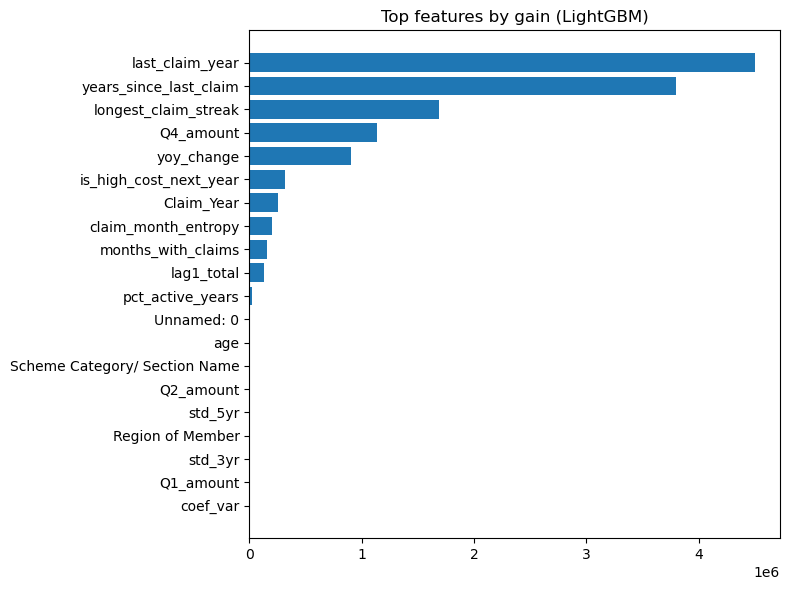

In [30]:

# -------------------------
# Summarize results
# -------------------------
print("\n=== Model Comparison ===")
for k,v in results.items():
    print(k, v)
best_model_name = min(results.items(), key=lambda kv: kv[1]["mae"])[0]
print("Best model by MAE:", best_model_name)
# map to saved object
best_obj = None
if best_model_name == "LightGBM":
    best_obj = best_lgb
elif best_model_name == "XGBoost":
    best_obj = best_xgb
elif best_model_name == "CatBoost":
    best_obj = best_cat
#elif best_model_name == "KerasANN":
#    best_obj = best_ann
#elif best_model_name == "MLPRegressor":
#    best_obj = mlp_pipe

# Save best model
joblib.dump(best_obj, os.path.join(OUT_DIR, "best_model.pkl"))
print("Saved best model to", os.path.join(OUT_DIR, "best_model.pkl"))

# -------------------------
# Feature importance (for tree models) + permutation importance
# -------------------------
# Build feature_names list (respecting onehot expansion)
def get_feature_names(preproc):
    out_names = []
    for name, trans, cols in preproc.transformers_:
        if name == "onehot":
            ohe = trans.named_steps["onehot"]
            names = list(ohe.get_feature_names_out(cols))
            out_names.extend(names)
        elif name == "target":
            out_names.extend(cols)
        elif name == "num":
            out_names.extend(cols)
    return out_names

feature_names = get_feature_names(preprocessor)
print("Processed feature count:", len(feature_names))

# Try to compute tree-based feature importance if we have a tree model available
tree_model_obj = None
for choice in ["LightGBM","XGBoost","CatBoost"]:
    if choice in results:
        tree_model_obj = {"LightGBM":best_lgb,"XGBoost":best_xgb,"CatBoost":best_cat}.get(choice)
        tree_name = choice
        break

if tree_model_obj is not None:
    print("\nComputing feature importances for", tree_name)
    # underlying estimator (pipeline) -> get .named_steps['model']
    underlying = tree_model_obj.named_steps["model"] if hasattr(tree_model_obj, "named_steps") else tree_model_obj
    try:
        # LightGBM
        if tree_name == "LightGBM":
            gains = underlying.booster_.feature_importance(importance_type='gain')
            df_fi = pd.DataFrame({"feature":feature_names, "gain":gains}).sort_values("gain", ascending=False)
        elif tree_name == "XGBoost":
            booster = underlying.get_booster()
            # XGBoost returns dict keyed by feature index as 'f0','f1'
            score = booster.get_score(importance_type='gain')
            # build array aligned to feature_names length
            gains = [score.get(f"f{i}", 0.0) for i in range(len(feature_names))]
            df_fi = pd.DataFrame({"feature":feature_names, "gain":gains}).sort_values("gain", ascending=False)
        elif tree_name == "CatBoost":
            gains = underlying.get_feature_importance(type='FeatureImportance')
            df_fi = pd.DataFrame({"feature":feature_names, "gain":gains}).sort_values("gain", ascending=False)
        else:
            df_fi = None
        if df_fi is not None:
            df_fi.to_csv(os.path.join(OUT_DIR,"feature_importances.csv"), index=False)
            print("Saved feature importances to models/feature_importances.csv")
            # Plot top 20
            top = df_fi.head(20).iloc[::-1]
            plt.figure(figsize=(8,6))
            plt.barh(top['feature'], top['gain'])
            plt.title(f"Top features by gain ({tree_name})")
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print("Could not compute built-in feature importance:", e)
else:
    print("No tree model available for built-in feature importance.")



Computing permutation importance (this may take a bit)...


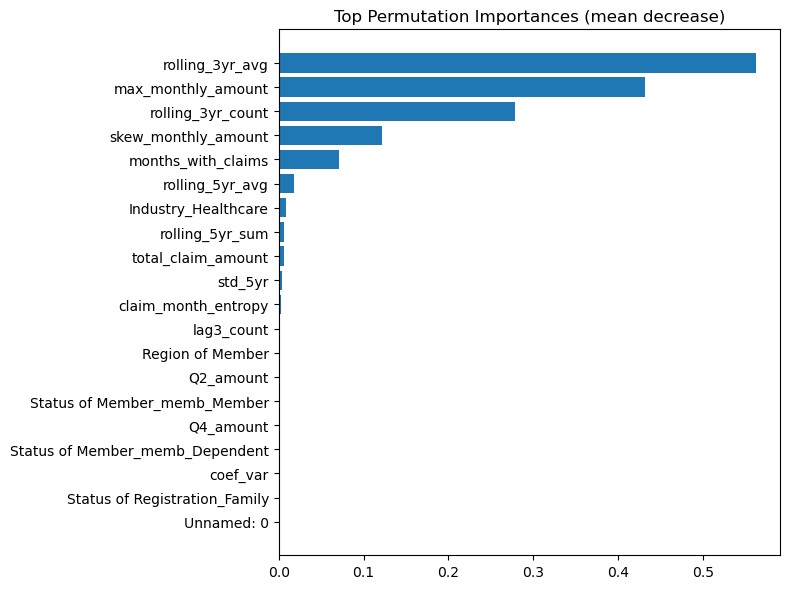


Computing SHAP values (TreeExplainer)...


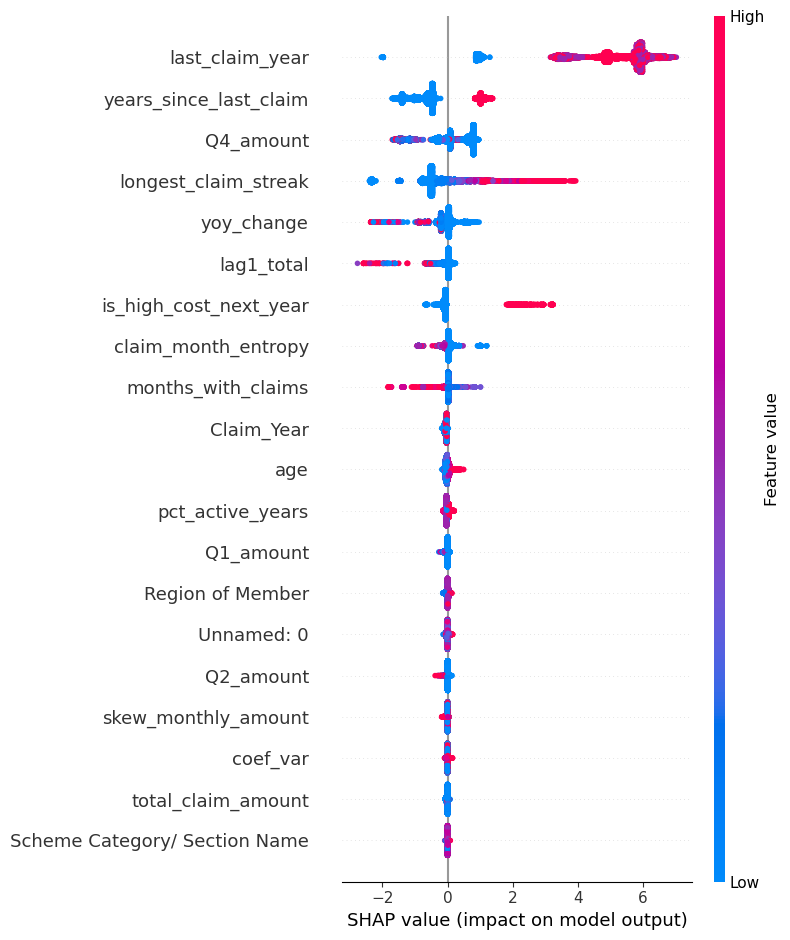

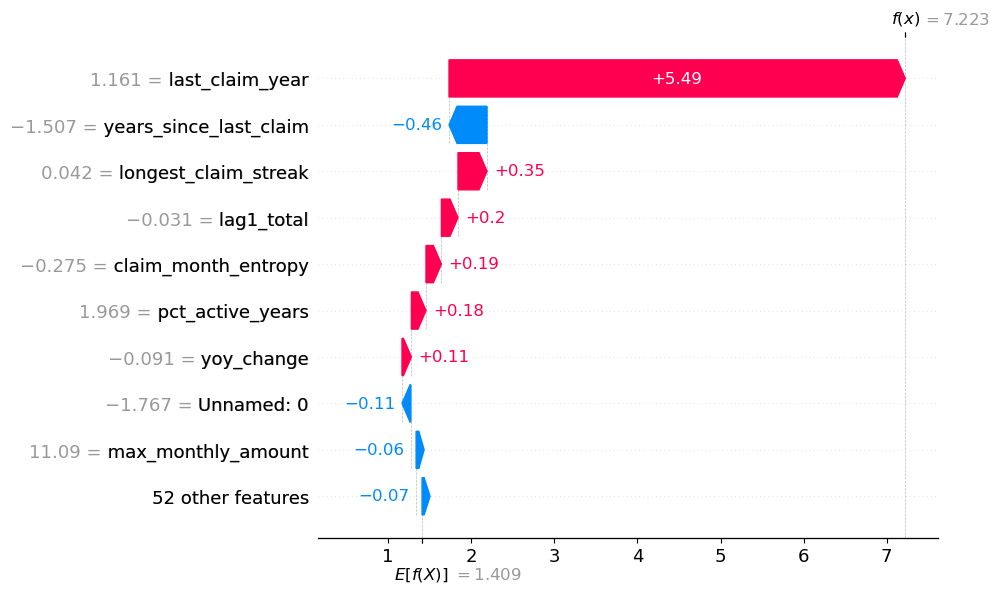


Running LIME (fixed numeric version)...

LIME explanation for test instance 0:
[('last_claim_year > 1.16', 4.500273566621949), ('longest_claim_streak > -0.04', 4.217988195780884), ('is_high_cost_next_year <= -0.11', -3.1327423898289424), ('-1.16 < first_claim_year <= 0.86', -1.5162378630659834), ('min_monthly_amount <= -0.02', 1.133675076052518), ('Claim_Year > 1.09', -1.0784934484685065), ('lag1_count <= -0.03', 0.8170116436990641), ('-0.07 < months_with_claims <= 0.00', 0.6260557352298726), ('yoy_change <= -0.09', 0.30142281814405003), ('lag2_total <= -0.03', 0.20086647401233224)]

LIME explanation for test instance 1:
[('months_with_claims > 0.00', -5.044577794652089), ('last_claim_year > 1.16', 4.55409117888052), ('longest_claim_streak > -0.04', 4.1746970124536), ('is_high_cost_next_year <= -0.11', -3.0192022368554645), ('-1.16 < first_claim_year <= 0.86', -1.4875430069828732), ('Claim_Year > 1.09', -1.02480858116155), ('lag1_count > -0.03', -0.7312818752610682), ('pct_active_year

In [ ]:

# Permutation importance (model-agnostic) using best_obj (works for any model)
try:
    print("\nComputing permutation importance (this may take a bit)...")
    perm = permutation_importance(best_obj, X_test, y_test, n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1)
    perm_idx = perm.importances_mean.argsort()[::-1]
    perm_features = np.array(feature_names)[perm_idx[:20]] if len(feature_names)>0 else X_test.columns[perm_idx[:20]]
    plt.figure(figsize=(8,6))
    plt.barh(range(len(perm_features)), perm.importances_mean[perm_idx[:len(perm_features)]][::-1])
    plt.yticks(range(len(perm_features)), perm_features[::-1])
    plt.title("Top Permutation Importances (mean decrease)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Permutation importance failed:", e)

# SHAP explainability - use TreeExplainer on underlying tree if available
if shap is not None and tree_model_obj is not None:
    try:
        print("\nComputing SHAP values (TreeExplainer)...")
        underlying = tree_model_obj.named_steps["model"] if hasattr(tree_model_obj, "named_steps") else tree_model_obj
        X_shap = preprocessor.transform(X_test)
        expl = shap.TreeExplainer(underlying)
        shap_values = expl.shap_values(X_shap)
        # Global summary
        shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=True)
        # Local waterfall for first instance
        shap.plots.waterfall(shap.Explanation(values=shap_values[0], base_values=expl.expected_value, data=X_shap[0], feature_names=feature_names))
    except Exception as e:
        print("SHAP TreeExplainer failed:", e)
else:
    print("\nSHAP not available or no tree model; skipping SHAP.")

# LIME local explanations (raw features)
# -------------------------
# LIME (fixed for categorical encodings)
# -------------------------
if LimeTabularExplainer is not None:
    try:
        print("\nRunning LIME (fixed numeric version)...")
        # Get preprocessed numeric data
        X_train_prep = preprocessor.transform(X_train)
        X_test_prep = preprocessor.transform(X_test)

        # Use numeric training data for explainer
        explainer = LimeTabularExplainer(
            training_data=np.array(X_train_prep),
            mode="regression",
            feature_names=feature_names,  # from preprocessed step
            verbose=False,
            random_state=42
        )

        # Prediction function that takes preprocessed input
        def predict_fn(z):
            # model here expects preprocessed numeric input
            model_step = best_obj.named_steps["model"] if hasattr(best_obj, "named_steps") else best_obj
            return model_step.predict(z)

        n_local = min(3, X_test_prep.shape[0])
        for i in range(n_local):
            exp = explainer.explain_instance(
                X_test_prep[i],
                predict_fn,
                num_features=min(10, len(feature_names))
            )
            print(f"\nLIME explanation for test instance {i}:")
            print(exp.as_list())
    except Exception as e:
        print("LIME (fixed version) failed:", e)


In [ ]:
# predict_claim.py
import joblib
import pandas as pd
import numpy as np

MODEL_PATH = "models/best_model.pkl"
model = joblib.load(MODEL_PATH)
print("Loaded model:", MODEL_PATH)

def predict_sample(sample_dict):
    df = pd.DataFrame([sample_dict])
    pred_log = model.predict(df)  # pipeline expects raw df
    pred = float(np.expm1(pred_log)[0])
    return pred

if __name__ == "__main__":
    # Example
    sample = {
        # fill with your dataset's feature names and values
        "Claimant Gender": "Female",
        "Claimant Age": 45,
        # include other categorical columns if present
    }
    print("Prediction (₹):", predict_sample(sample))


In [ ]:
pip install catboost tensorflow

In [ ]:
pip install numpy pandas scikit-learn joblib matplotlib category_encoders shap lime scikeras xgboost lightgbm